## Objective
Train a model to predict the class in _CIFAR-10_, with the following requirements
- Apply the following augmentations to the data
    - **RandomCrop**
    - **Cutout (<img src="https://render.githubusercontent.com/render/math?math=16x16">)**
    - **Rotation (<img src="https://render.githubusercontent.com/render/math?math=\pm%205^\circ">)**
- No. of Epochs - **40**
- Use **Layer Normalization** instead of Batch Norm
- Use LR Scheduler (**ReduceLROnPlateau**) while training


Once trained check the misclassified images and use **GradCAM** to visualize the layer activations for these misclassified images

## Imports

In [1]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Utils
import sys # Update the system path for custom imports
import numpy as np # For Vectorized calculation
from importlib import reload # Used to reload the functions

### Pull the files from GitHub

In [2]:
# Get custom dependencies from GitHub
# Create a folder to contain it
!mkdir -p ./dependencies/models/

# Download the required files
# `resnet.py` defines the ResNet Network architecture to use
#        Reference: https://github.com/kuangliu/pytorch-cifar
# `main.py` contains the train and test code to train the model
# `utils.py` contains the code to load and transform the data
# `visualize.py` contains code to visualize the results (accuracy and loss plots,
#        misclassified images etc.)

# Base URL defining the repo name and the path at which the file are located
base_url = 'https://raw.githubusercontent.com/NarutoScoo/EVA6/main/Assignments/Dependencies'

# Location at which the files will be downloaded
dependencies = './dependencies/'

# List of files to get the from the path defined (`base_url`)
# Format: <filename> or <dirname>/<filename>
list_of_files = ['models/resnet.py', 'main.py', 'utils.py', 'visualize.py']

# Iterate through and download the required files
for filename in list_of_files:
    !wget {base_url}/{filename} -O {dependencies}/{filename}
    
# Add dependencies to the system path
# to import the files
sys.path.append (dependencies)

# Import the modules
from dependencies.models import resnet
from dependencies import utils, visualize

--2021-07-04 00:18:27--  https://raw.githubusercontent.com/NarutoScoo/EVA6/main/Assignments/Dependencies/models/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5944 (5.8K) [text/plain]
Saving to: ‘./dependencies//models/resnet.py’

./dependencies//mod 100%[===================>]   5.80K  --.-KB/s    in 0s      

2021-07-04 00:18:27 (80.3 MB/s) - ‘./dependencies//models/resnet.py’ saved [5944/5944]

--2021-07-04 00:18:27--  https://raw.githubusercontent.com/NarutoScoo/EVA6/main/Assignments/Dependencies/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, 

In [3]:
# Disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Understand the data

In [4]:
import utils; reload (utils)

# Load a samples
samples = utils.load_samples (
    dataset='CIFAR10' # 'MNIST' or 'CIFAR10'
)

Files already downloaded and verified


### Display the statistics of the dataset

In [5]:
# Describe the data samples
utils.describe_data (samples)



--------------------------------------------------
No. of samples: 50000
Size of the sample: torch.Size([50000, 32, 32, 3])
Minimum value: tensor(0.)
Maximum value: tensor(1.)
Mean of the sample: tensor([0.4914, 0.4822, 0.4465])
Standard Deviation of the sample: tensor([0.2470, 0.2435, 0.2616])
No. of classes: 10
Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
--------------------------------------------------




### Display sample images from the dataset

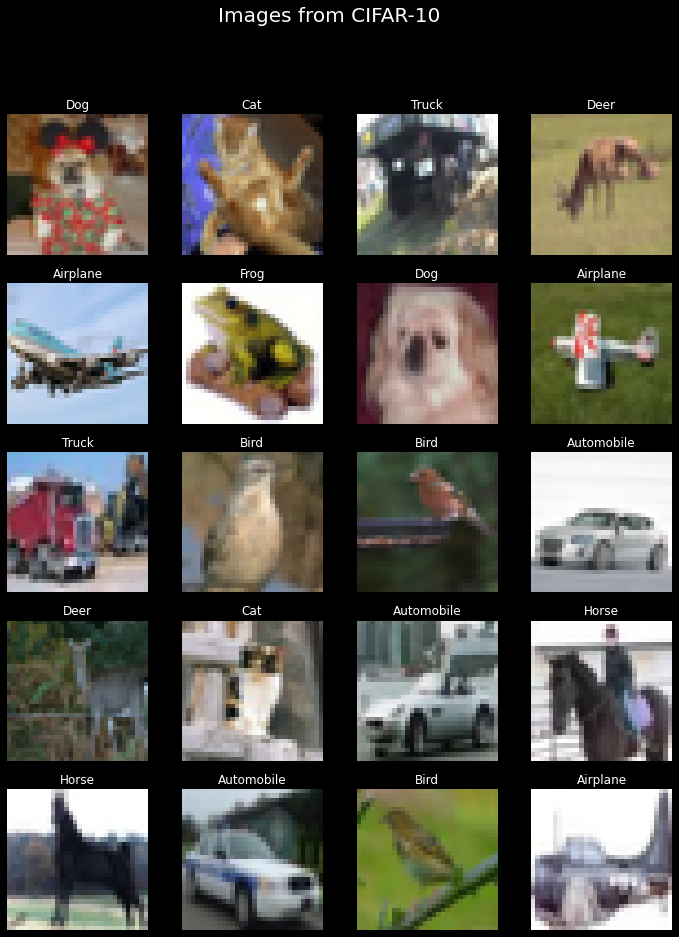

In [6]:
import visualize; reload (visualize)

visualize.display_samples (
    data=samples.data, 
    fig_title='Images from CIFAR-10',
    nrows_ncols=(5, 4),
    image_r_plot='image',
    figsize=(12, 15),
    titles=np.array (samples.targets),
    label_map={v:k for k, v in samples.class_to_idx.items ()}
)

### Check the distribution of the images across the classes

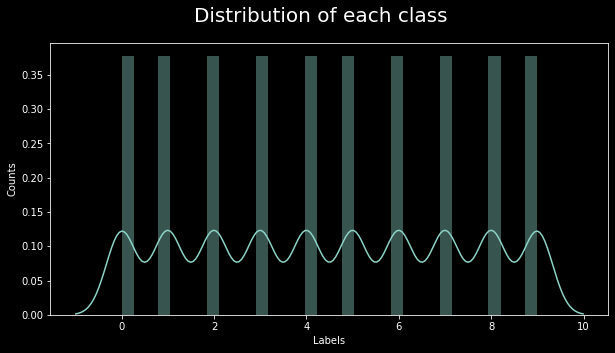

In [7]:
import visualize; reload (visualize)

# Display the distribution of each class
visualize.display_results (
    data=[samples.targets],
    fig_title='Distribution of each class',
    nrows_ncols=(1, 1),
    figsize=(10, 5),
    image_r_plot='hist',
    titles=[('', 'Labels', 'Counts')]
)

All the classes have equal representative samples (balanced class)



## Load the data
Define the data loaders for train and test with $batch\_size = 128$.

In [8]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Import the function to load the training
# and the test data loaders
# Reload updates the functions if any changes are made
# instead of having to restart the kernel each time
import utils; reload (utils)

# Augmentaion using Albumentations
import albumentations as A
from torchvision import transforms

# Get the train and test loaders
train_loader, test_loader = utils.load_train_test (
    mode='both', # Mode indicates whether train/test is required
    dataset='CIFAR10',
    additional_transforms={
        'torchvision': [
            transforms.RandomRotation (5.0),
            transforms.RandomCrop (32, padding=4)
        ],
        'albumentation': A.Compose ([
            A.Cutout (num_holes=1, max_h_size=16, max_w_size=16, p=0.5)
        ])
    },
    batch_size=batch_size, 
    mean_std=[
        [0.4914, 0.4822, 0.4465],
        [0.2470, 0.2435, 0.2616]
    ], # Mean and Standard deviation across the 3 channels
    **kwargs
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print (f'No. of training batches: {len (train_loader)}\nNo. of test batches: {len (test_loader)}')

No. of training batches: 391
No. of test batches: 79


## Log the results from different models

In [10]:
# Log the results for each of the models
model_logs = {
    'batch_norm': {},
    'layer_norm': {},
}

## Model using Layer Normalization

|![layer_norm](../../Images/markdown_images/layer_norm.png)|
|:---:|
|_Layer Normalization[1](#references)_|

In [11]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.01

# Normalization strategy
# one of 'group_norm', 'layer_norm', 
# 'batch_norm' or 'instance_norm'
# Tying out instance norm just to see how it works
normalization = 'layer_norm'

# Import the class with the network architecture
# Reload the model
from models import resnet; reload (resnet)

# Create a model object
model = resnet.ResNet18 (
    normalization=normalization
).to (device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNorm-14          [-1, 128,

**Note:** Summary of the network shows as GroupNorm. Group Norm was used to implement LayerNorm by setting the number of groups to 1

### Train and Validate

In [12]:
import main; reload (main) 

# Initialize the model instance
model = resnet.ResNet18 (
    normalization=normalization
).to (device)

# Start the training
model_logs = main.main (
    model=model,
    epochs=40, # Train the model for n epochs
    regularization=None, # Either 'None', 'l1', 'l2' or 'l1_l2'
    l1_lambda=None, # None, 0.0001
    l2_lambda=None, # None, 0.001
    normalization=normalization, # batch_norm, layer_norm
    criteria='cross_entropy', # or nll [loss criteria]
    optimizer=main.get_optimizer (
        model, optimizer='sgd', 
        learning_rate=0.05, momentum=0.9
    ),
    lr_schedulers=['ReduceLROnPlateau'], # Pass a list of schedulers
    train_loader=train_loader,
    test_loader=test_loader,
    model_logs=model_logs # Log the results
)

  0%|          | 0/391 [00:00<?, ?it/s]

Iteration 1


Loss=2.0642; Accuracy=17.76; Learning Rate=0.0400: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]



Train set: Loss=2.0330; Accuracy=11316/50000 (22.63%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.9836; Accuracy=2470/10000 (24.70%)


Iteration 2


Loss=1.9542; Accuracy=24.85; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]



Train set: Loss=1.8918; Accuracy=14285/50000 (28.57%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.8195; Accuracy=3162/10000 (31.62%)


Iteration 3


Loss=2.0487; Accuracy=30.67; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Train set: Loss=1.7484; Accuracy=17577/50000 (35.15%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.6268; Accuracy=3996/10000 (39.96%)


Iteration 4


Loss=1.6996; Accuracy=35.85; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]



Train set: Loss=1.7267; Accuracy=18262/50000 (36.52%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.6330; Accuracy=4228/10000 (42.28%)


Iteration 5


Loss=1.4182; Accuracy=40.13; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=1.5368; Accuracy=22219/50000 (44.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.4415; Accuracy=4911/10000 (49.11%)


Iteration 6


Loss=1.5333; Accuracy=44.75; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]



Train set: Loss=1.5826; Accuracy=20833/50000 (41.67%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.4017; Accuracy=4853/10000 (48.53%)


Iteration 7


Loss=1.4228; Accuracy=48.00; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=1.4163; Accuracy=24234/50000 (48.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.2554; Accuracy=5486/10000 (54.86%)


Iteration 8


Loss=1.3464; Accuracy=51.91; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=1.2969; Accuracy=26904/50000 (53.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.1085; Accuracy=5955/10000 (59.55%)


Iteration 9


Loss=1.1078; Accuracy=54.41; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=1.2099; Accuracy=28234/50000 (56.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.0406; Accuracy=6254/10000 (62.54%)


Iteration 10


Loss=1.1140; Accuracy=57.18; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=1.1059; Accuracy=30378/50000 (60.76%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.9969; Accuracy=6550/10000 (65.50%)


Iteration 11


Loss=0.9868; Accuracy=59.37; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=1.1486; Accuracy=29386/50000 (58.77%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=1.0049; Accuracy=6505/10000 (65.05%)


Iteration 12


Loss=0.8935; Accuracy=61.55; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=1.0384; Accuracy=31592/50000 (63.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.9071; Accuracy=6792/10000 (67.92%)


Iteration 13


Loss=1.0580; Accuracy=63.42; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.9618; Accuracy=33009/50000 (66.02%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.8383; Accuracy=7044/10000 (70.44%)


Iteration 14


Loss=1.0202; Accuracy=64.96; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]



Train set: Loss=0.9684; Accuracy=32740/50000 (65.48%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.8064; Accuracy=7245/10000 (72.45%)


Iteration 15


Loss=0.9024; Accuracy=66.75; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.9064; Accuracy=33980/50000 (67.96%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.7612; Accuracy=7299/10000 (72.99%)


Iteration 16


Loss=0.9220; Accuracy=68.57; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.8766; Accuracy=34706/50000 (69.41%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.7828; Accuracy=7283/10000 (72.83%)


Iteration 17


Loss=0.7107; Accuracy=69.40; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.8079; Accuracy=35818/50000 (71.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.6691; Accuracy=7646/10000 (76.46%)


Iteration 18


Loss=0.5623; Accuracy=70.90; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.8097; Accuracy=35715/50000 (71.43%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.7273; Accuracy=7527/10000 (75.27%)


Iteration 19


Loss=0.8234; Accuracy=72.11; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.7398; Accuracy=36957/50000 (73.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.6072; Accuracy=7882/10000 (78.82%)


Iteration 20


Loss=0.8528; Accuracy=73.28; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.7621; Accuracy=36586/50000 (73.17%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.6060; Accuracy=7865/10000 (78.65%)


Iteration 21


Loss=0.7124; Accuracy=74.09; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.7468; Accuracy=36953/50000 (73.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.6543; Accuracy=7828/10000 (78.28%)


Iteration 22


Loss=0.6544; Accuracy=75.06; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.7326; Accuracy=36905/50000 (73.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.5735; Accuracy=7977/10000 (79.77%)


Iteration 23


Loss=0.6561; Accuracy=75.54; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.6783; Accuracy=37964/50000 (75.93%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.5431; Accuracy=8089/10000 (80.89%)


Iteration 24


Loss=0.5673; Accuracy=76.46; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.6420; Accuracy=38766/50000 (77.53%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.5230; Accuracy=8194/10000 (81.94%)


Iteration 25


Loss=0.5182; Accuracy=77.37; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.6070; Accuracy=39411/50000 (78.82%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4940; Accuracy=8303/10000 (83.03%)


Iteration 26


Loss=0.6134; Accuracy=77.96; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.6262; Accuracy=38988/50000 (77.98%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.5114; Accuracy=8279/10000 (82.79%)


Iteration 27


Loss=0.5144; Accuracy=78.63; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.6441; Accuracy=38625/50000 (77.25%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.5269; Accuracy=8253/10000 (82.53%)


Iteration 28


Loss=0.5903; Accuracy=79.24; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.5429; Accuracy=40520/50000 (81.04%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4529; Accuracy=8393/10000 (83.93%)


Iteration 29


Loss=0.5954; Accuracy=79.73; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]



Train set: Loss=0.5689; Accuracy=39948/50000 (79.90%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4843; Accuracy=8346/10000 (83.46%)


Iteration 30


Loss=0.4671; Accuracy=80.23; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]



Train set: Loss=0.5479; Accuracy=40370/50000 (80.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4614; Accuracy=8462/10000 (84.62%)


Iteration 31


Loss=0.7006; Accuracy=80.97; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.5141; Accuracy=40990/50000 (81.98%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4170; Accuracy=8580/10000 (85.80%)


Iteration 32


Loss=0.6142; Accuracy=81.22; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.5026; Accuracy=41162/50000 (82.32%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4429; Accuracy=8470/10000 (84.70%)


Iteration 33


Loss=0.3887; Accuracy=81.45; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.5086; Accuracy=41007/50000 (82.01%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4213; Accuracy=8530/10000 (85.30%)


Iteration 34


Loss=0.6577; Accuracy=81.86; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]



Train set: Loss=0.4839; Accuracy=41468/50000 (82.94%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.3919; Accuracy=8660/10000 (86.60%)


Iteration 35


Loss=0.4859; Accuracy=82.48; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.4975; Accuracy=41322/50000 (82.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4163; Accuracy=8637/10000 (86.37%)


Iteration 36


Loss=0.5399; Accuracy=82.64; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.4697; Accuracy=41859/50000 (83.72%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.3977; Accuracy=8644/10000 (86.44%)


Iteration 37


Loss=0.4059; Accuracy=83.11; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.4935; Accuracy=41357/50000 (82.71%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.4228; Accuracy=8515/10000 (85.15%)


Iteration 38


Loss=0.3850; Accuracy=83.55; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]



Train set: Loss=0.4276; Accuracy=42488/50000 (84.98%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.3631; Accuracy=8754/10000 (87.54%)


Iteration 39


Loss=0.3415; Accuracy=83.68; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.4099; Accuracy=42811/50000 (85.62%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss=0.3619; Accuracy=8770/10000 (87.70%)


Iteration 40


Loss=0.5010; Accuracy=84.35; Learning Rate=0.0400: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Train set: Loss=0.4162; Accuracy=42813/50000 (85.63%)



Test set: Loss=0.3638; Accuracy=8743/10000 (87.43%)


Best Model had a Training Accuracy of 85.63 & a Test Accuracy of 87.70


### Plot Results

#### Accuracy and Losses

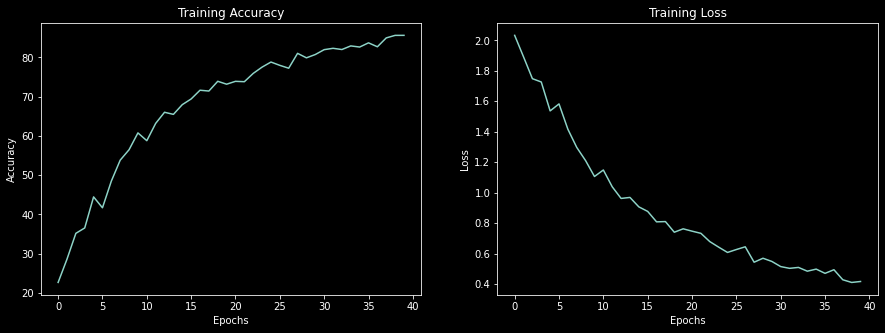

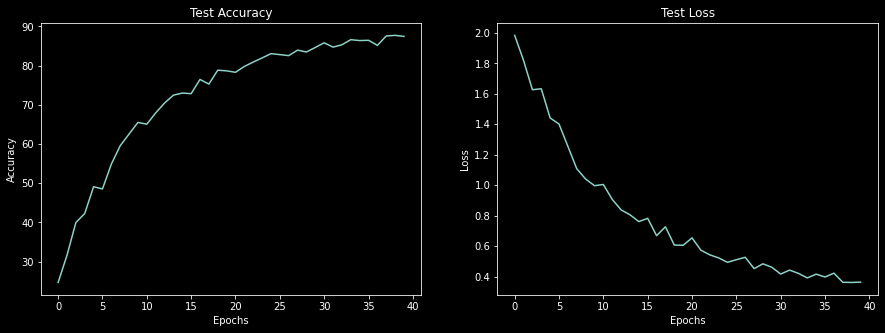

In [13]:
# Import the functions to plot the results
import visualize; reload (visualize)

# Plot the training accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[
        model_logs [normalization] ['training_accuracy'],
        model_logs [normalization] ['training_losses'],
    ],
    mode='training'
)

# Plot the test accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[
        model_logs [normalization] ['test_accuracy'],
        model_logs [normalization] ['test_losses'],
    ],
    mode='test'
)

- Training accuracy is still not as high as possible; there's still room for improving the results further

#### Misclassified Images

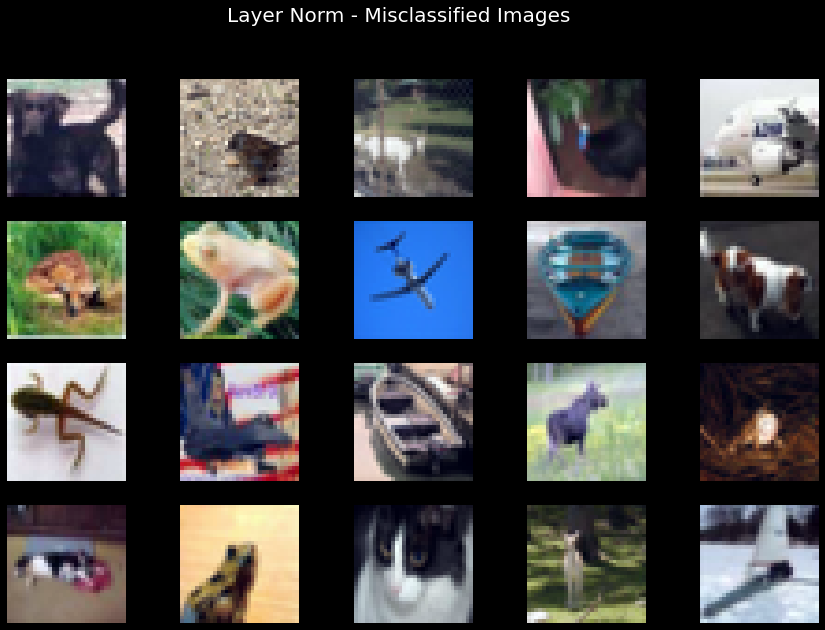

In [16]:
import visualize; reload (visualize)

misclassified_images, random_idx = visualize.display_misclassified (
    misclassified_images=model_logs [normalization] ['misclassified_images'],
    fig_title = " ".join (normalization.split ("_")).title (),
    figsize=(15, 10),
    nrows_ncols=(4, 5)
)

#### Visualizing Class Activation Maps using GradCam

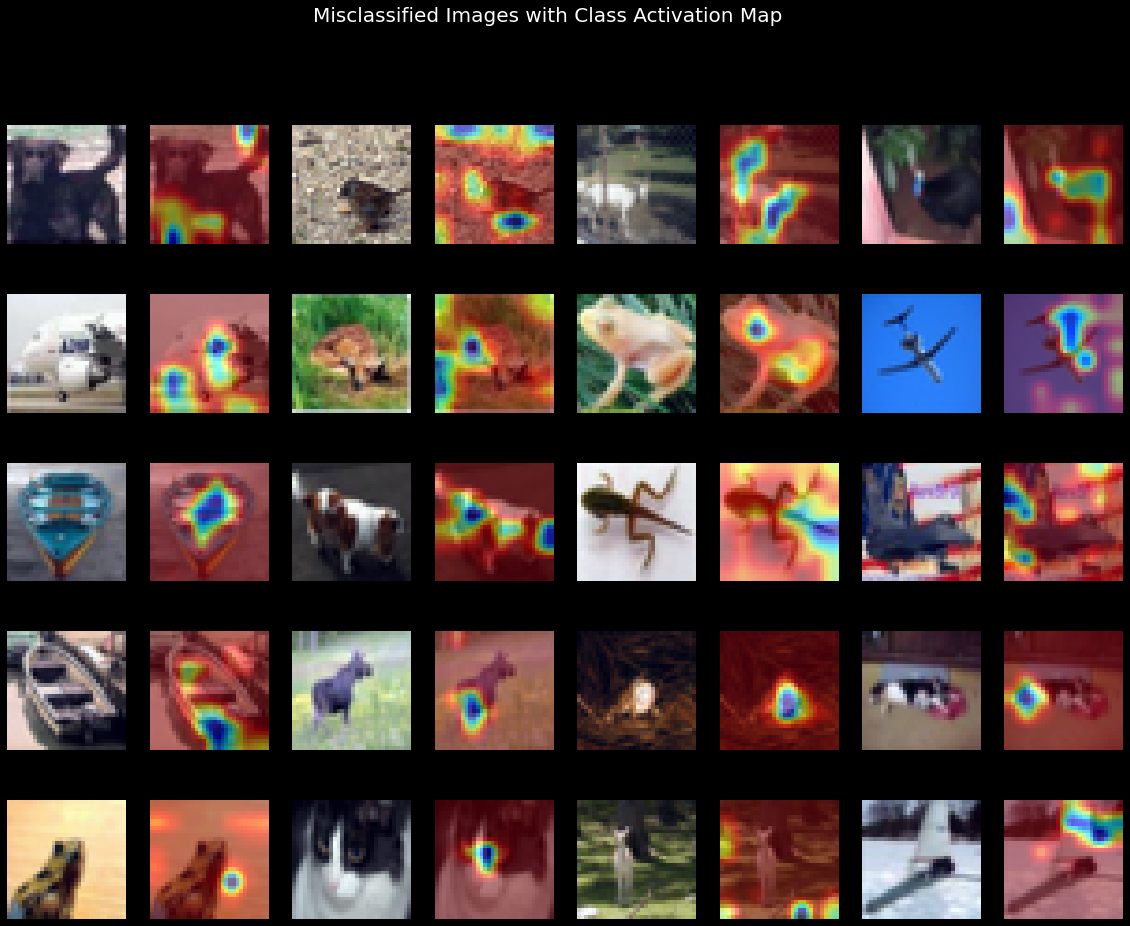

In [17]:
import visualize; reload (visualize)

# Install the packages
!pip install grad-cam
!pip install ttach

# Visalize the activation maps
visualize.display_activation_map (
    model=model,
    target_layer=model.layer3 [-1],
    input_tensor=model_logs [normalization] ['misclassified_images'] [random_idx].squeeze (),
    misclassified_images=misclassified_images,
    nrows_ncols=(5, 4*2),
    figsize=(20, 15)
)

- We see from the output of the activation map that it at times completely misses the object in question (like the image of the cat and the frog on the last row)

<a name='references'></a>
## References

1. Wu, Y. and He, K., 2018. Group normalization. In Proceedings of the European conference on computer vision (ECCV) (pp. 3-19
2. Future, C. T. B. (2020, August 9). Group Normalization. Committed towards Better Future. https://amaarora.github.io/2020/08/09/groupnorm.html
3. https://github.com/jacobgil/pytorch-grad-cam
4. https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
5. https://www.kaggle.com/skylord/grad-cam-on-resnext